In [1]:
import numpy as np
import pandas as pd
import tqdm
import jax
import jax.numpy as jnp
import string
import tensorflow as tf
import time
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords

## Data Preprocessing

In [2]:
data = pd.read_csv('./data/raw data/raw_data.csv', header=0, names=['text'], usecols=[1])
print(f'Data Shape: {data.shape}')
data.head()

Data Shape: (13368, 1)


,text
0,"Sally Forrest, an actress-dancer who graced th..."
1,A middle-school teacher in China has inked hun...
2,A man convicted of killing the father and sist...
3,Avid rugby fan Prince Harry could barely watch...
4,A Triple M Radio producer has been inundated w...


In [3]:
# remove punctuation
punctuations = string.punctuation
def remove_punctuation(txt):
    for char in punctuations:
        if char in txt:
            txt = txt.replace(char, "")
    return txt

# change to lower caps
data['text'] = data['text'].str.lower()

# remove punctuations
data['text'] = data['text'].apply(remove_punctuation)

In [4]:
# remove stopwords
# read stopwords from data/raw data/stopwords.txt
stop_words = []
with open('./data/raw data/stopwords.txt', 'r') as f:
    for line in f:
        stop_words.append(line.strip())

def remove_stopwords(txt):
    txt = [word for word in txt.split() if word not in stop_words]
    return ' '.join(txt)

data['text'] = data['text'].apply(remove_stopwords)

In [5]:
# split each row into list of words
data_lst = data['text'].apply(lambda txt: txt.split(" "))

# select number of rows to be used as training data
nrows = 200
random_indices = np.random.randint(low=0, high=len(data_lst), size=nrows)
data_lst = data_lst[random_indices].reset_index(drop=True)

print(f'Number of rows of data: {len(data_lst)}')
data_lst[:5]

Number of rows of data: 200


0    [cornish, coast, toilet, block, stunning, sea,...
1    [thousands, tourists, residents, basking, hot,...
2    [rare, series, interlinked, operations, 12, pa...
3    [jonjo, o’neill, doubts, shouting, particular,...
4    [motherofthree, credited, slice, pizza, saving...
Name: text, dtype: object

In [6]:
# vocab dict
vocab, index = {}, 1
vocab['<pad>'] = 0
for line in data_lst:
    for word in line:
        if word not in vocab:
            vocab[word] = index
            index += 1

# inverse_vocab dict
inverse_vocab = {}
for word, index in vocab.items():
    inverse_vocab[index] = word

print(f'Vocab size: {len(vocab)}')

Vocab size: 14829


In [7]:
# sequences
sequences = []
for line in data_lst:
    vectorized_line = [vocab[word] for word in line]
    sequences.append(vectorized_line)

## Split Train and Test Sets

In [8]:
# split into train and test sets
# choose 20 random sequences
ntest = 20
test_indices = np.random.randint(low=0, high=len(sequences), size=ntest)
test_sequences = [sequences[i] for i in test_indices]
train_sequences = [sequences[i] for i in range(len(sequences)) if i not in test_indices]

In [9]:
# function to generate samples
def generate_training_data(sequences, window_size, num_ns, vocab_size, seed):
  # Elements of each training example are appended to these lists.
  targets, contexts, labels = [], [], []

  # Build the sampling table for `vocab_size` tokens.
  sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)

  # Iterate over all sequences (sentences) in the dataset.
  for sequence in tqdm(sequences):

    # Generate positive skip-gram pairs for a sequence (sentence).
    positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
          sequence,
          vocabulary_size=vocab_size,
          sampling_table=sampling_table,
          window_size=window_size,
          negative_samples=0,
          shuffle=True)

    # Iterate over each positive skip-gram pair to produce training examples
    # with a positive context word and negative samples.
    for target_word, context_word in positive_skip_grams:
      context_class = tf.reshape(tf.constant([context_word], dtype="int64"), (1,1))
      negative_sampling_candidates, _, _ = tf.random.log_uniform_candidate_sampler(
          true_classes=context_class,
          num_true=1,
          num_sampled=num_ns,
          unique=True,
          range_max=vocab_size,
          seed=seed,
          name="negative_sampling")

      # Build context and label vectors (for one target word)
      context = tf.concat([tf.squeeze(context_class,1), negative_sampling_candidates], 0)
      label = tf.constant([1] + [0]*num_ns, dtype="int64")

      # Append each element from the training example to global lists.
      targets.append(target_word)
      contexts.append(context)
      labels.append(label)

  return targets, contexts, labels

In [10]:
# function to generate testing data
def generate_testing_data(sequences, vocab_size, window_size):
    targets, contexts, labels = [], [], []
    for sequence in tqdm(sequences):
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocab_size,
            window_size=window_size,
            negative_samples=0)
    for target_word, context_word in positive_skip_grams:
        targets.append(target_word)
        contexts.append(context_word)
        labels.append(1)
    return targets, contexts, labels

In [11]:
# generate training data
window_size = 5
num_ns = 4
vocab_size = len(vocab)
seed = 4212

targets, contexts, labels = generate_training_data(sequences=train_sequences,
                                                 window_size=window_size,
                                                 num_ns=num_ns,
                                                 vocab_size=vocab_size,
                                                 seed=seed)

targets = np.array(targets)
contexts = np.array(contexts)
labels = np.array(labels)

print(f'targets shape: {targets.shape}')
print(f'contexts shape: {contexts.shape}')
print(f'labels shape: {labels.shape}')

100%|██████████| 182/182 [02:30<00:00,  1.21it/s]


targets shape: (316229,)
contexts shape: (316229, 5)
labels shape: (316229, 5)


In [12]:
# generate testing data
targets_test, contexts_test, labels_test = generate_testing_data(sequences=test_sequences,
                                                                    vocab_size=vocab_size,
                                                                    window_size=window_size)

targets_test = np.array(targets_test)
contexts_test = np.array(contexts_test)
labels_test = np.array(labels_test)

print(f'targets_test shape: {targets_test.shape}')
print(f'contexts_test shape: {contexts_test.shape}')
print(f'labels_test shape: {labels_test.shape}')

100%|██████████| 20/20 [00:00<00:00, 165.09it/s]

targets_test shape: (2280,)
contexts_test shape: (2280,)
labels_test shape: (2280,)


**Sanity Check on quality of training and testing data**

In [13]:
# training data
print(f"target_index    : {targets[0]}")
print(f"target_word     : {inverse_vocab[targets[0]]}")
print(f"context_indices : {contexts[0]}")
print(f"context_words   : {[inverse_vocab[c] for c in contexts[0]]}")
print(f"label           : {labels[0]}")

print("target  :", targets[0])
print("context :", contexts[0])
print("label   :", labels[0])

target_index    : 128
target_word     : frank
context_indices : [ 132   39 1582 1593 1067]
context_words   : ['told', 'sale', 'monitored', 'authority', 'quiet']
label           : [1 0 0 0 0]
target  : 128
context : [ 132   39 1582 1593 1067]
label   : [1 0 0 0 0]


In [14]:
# testing data
print(f"target_index    : {targets_test[0]}")
print(f"target_word     : {inverse_vocab[targets_test[0]]}")
print(f"context_index : {contexts_test[0]}")
print(f"context_word   : {inverse_vocab[contexts_test[0]]}")
print(f"label           : {labels_test[0]}")

print("target  :", targets_test[0])
print("context :", contexts_test[0])
print("label   :", labels_test[0])

target_index    : 11131
target_word     : rome
context_index : 6769
context_word   : starts
label           : 1
target  : 11131
context : 6769
label   : 1


## Minimizing Objective Function for SGNS

$$

\min_{\theta} = \frac{1}{N} \sum_{i=1}^{N} [log \sigma(u_{ic}^T)  + \sum_{k=1}^{K}log \sigma(-u_{kc}^T v_{iw})]

\\
\\
\theta = [U, V]

$$

In [15]:
# sigmoid function
def sigmoid(x):
    """Inputs a real number, outputs a real number"""
    return 1 / (1 + jnp.exp(-x))


In [16]:
# define a local loss function
# where it takes a params argument where params = [U, V]
# U and V are the embedding matrices. Dimension of U : (n x |v|), Dimension of V : (|v| x n)
# target is the index of the target word vector in the V matrix. Dimension: (1,)
# context is the index of the context word vectors in the U matrix. Dimension: (n,)
# returns a real number

def local_loss(params,
               target,
               context):
    """
    Input (example)
    target = (188,)
    context = (93, 40, 1648, 1659, 1109)
    params = [V, U]
        V: matrix of dim (n x |v|)
        U: matrix of dim (|v| x n)
            n = embedding dimension, |v| = vocab size

    Outputs the local_loss -> real number
    """
    target = target.astype(int)
    context = context.astype(int)
    V_embedding =params[0][0]
    U_embedding = params[0][1]
    
    v_t = V_embedding.T[target]; print(f'v_t shape: {v_t.shape}') # shape (300,)
    u_pos = U_embedding[context[0]]; print(f'u_pos shape: {u_pos.shape}')  # shape(300,)
    u_neg = U_embedding[context[1:]]; print(f'u_neg shape: {u_neg.shape}')  # shape(4, 300)

    return -jnp.log(sigmoid(jnp.dot(u_pos.T, v_t))) - jnp.sum(jnp.log(sigmoid(-jnp.dot(u_neg, v_t))))

In [17]:
# vmap the local loss across a batch of data points
loss_all = jax.vmap(local_loss, in_axes=(None, 0, 0))

@jax.jit
def loss(params, targets, contexts):
    """return average of all the local losses"""
    all_losses = loss_all(params, targets, contexts)
    return jnp.mean(all_losses)

# get the loss value and gradient
loss_value_and_grad = jax.jit( jax.value_and_grad(loss) )

In [18]:
# set up
n = 300
v = len(vocab)
V = np.random.normal(0, 1, size=(n, v)) / np.sqrt(v)
U = np.random.normal(0, 1, size=(v, n)) / np.sqrt(v)
params = [(V, U)]
targets_data = targets.astype(float)
contexts_data = contexts.astype(float)
labels_data = labels.astype(float)

print(f'V shape: {V.shape}')
print(f'U shape: {U.shape}')
print(f'targets_data shape: {targets_data.shape}')
print(f'contexts_data shape: {contexts_data.shape}')
print(f'labels_data shape: {labels_data.shape}')

V shape: (300, 14829)
U shape: (14829, 300)
targets_data shape: (316229,)
contexts_data shape: (316229, 5)
labels_data shape: (316229, 5)


In [19]:
# train using stochastic gradient descent

# number of training examples
N = len(targets_data)

# learning rate
lr = 10.

# number of epochs
n_epochs = 100

# batch size
batch_size = 1000

# number of batches per epoch
n_batches = N // batch_size

# keep track of losses
epoch_losses = []

# training the network
for epoch in range(n_epochs):
    start_time = time.time()
    # shuffle data
    perm = np.random.permutation(N)
    targets_epoch = targets_data[perm]
    contexts_epoch = contexts_data[perm]
    labels_epoch = labels_data[perm]

    # decrease learning rate
    if epoch == 20 or epoch == 50 or epoch == 75 or epoch == 90:
        lr /= 2.

    # losses in each epoch
    losses = []
    for batch in range(n_batches):
        targets_batch = targets_epoch[batch*batch_size: (batch+1)*batch_size]
        contexts_batch = contexts_epoch[batch*batch_size: (batch+1)*batch_size]
        labels_batch = labels_epoch[batch*batch_size: (batch+1)*batch_size]

        # calculate and save losses
        loss_value, gradient = loss_value_and_grad(params, targets_batch, contexts_batch)
        losses.append(loss_value)

        params = [(V - lr*dV, U - lr*dU) for (V, U), (dV, dU) in zip(params, gradient)]

    epoch_losses.append(np.mean(losses))

    end_time = time.time()
    if epoch % 1 == 0:
        print(f"Epoch {epoch+1}/{n_epochs} \t loss = {np.mean(epoch_losses)} \t time = {end_time - start_time:.2f}s")

v_t shape: (300,)
u_pos shape: (300,)
u_neg shape: (4, 300)
Epoch 1/100 	 loss = 3.2259926795959473 	 time = 18.18s
Epoch 2/100 	 loss = 2.746544361114502 	 time = 16.72s
Epoch 3/100 	 loss = 2.474778890609741 	 time = 16.10s
Epoch 4/100 	 loss = 2.303170680999756 	 time = 16.31s
Epoch 5/100 	 loss = 2.183927536010742 	 time = 15.84s
Epoch 6/100 	 loss = 2.0956599712371826 	 time = 16.00s
Epoch 7/100 	 loss = 2.0273597240448 	 time = 17.33s
Epoch 8/100 	 loss = 1.9727609157562256 	 time = 16.10s
Epoch 9/100 	 loss = 1.9279817342758179 	 time = 16.50s
Epoch 10/100 	 loss = 1.8905121088027954 	 time = 15.98s
Epoch 11/100 	 loss = 1.8586186170578003 	 time = 16.65s
Epoch 12/100 	 loss = 1.8310546875 	 time = 17.51s
Epoch 13/100 	 loss = 1.8068960905075073 	 time = 17.60s
Epoch 14/100 	 loss = 1.7854450941085815 	 time = 16.63s
Epoch 15/100 	 loss = 1.766162395477295 	 time = 16.03s
Epoch 16/100 	 loss = 1.7485976219177246 	 time = 16.74s
Epoch 17/100 	 loss = 1.7324066162109375 	 time = 1

Text(0, 0.5, 'Loss')

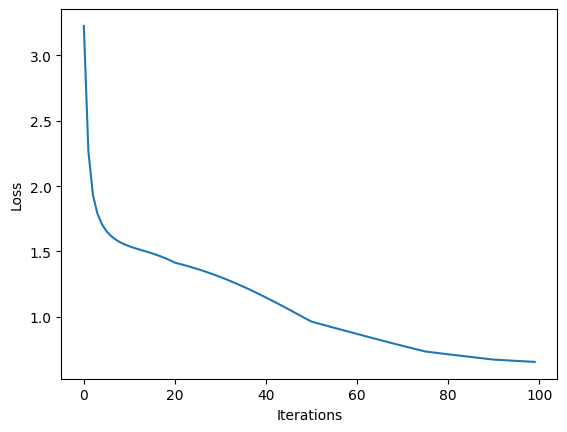

In [20]:
# plot losses
import matplotlib.pyplot as plt
plt.plot(epoch_losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [21]:
# copy U and V
V_trained = np.copy(params[0][0])
U_trained = np.copy(params[0][1])

# check dimensions of U and V, 100 epochs, lr = 1, batch_size = 500
print(f'V_trained shape: {V_trained.shape}')
print(f'U_trained shape: {U_trained.shape}')

V_trained shape: (300, 14829)
U_trained shape: (14829, 300)


## Evaluate against test set

In [22]:
# define a function that takes in as input target and vocab length
# outputs a one-hot vector, x_hot of dimension = (vocab_length,)
def get_x_hot(target_idx, vocab_length):
    x_hot = np.zeros(vocab_length, dtype=float)
    x_hot[target_idx] = 1.0
    return jnp.array(x_hot)

# define softmax function
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

print(softmax(np.array([1, 2, 3])))


[0.09003057 0.24472847 0.66524096]


In [23]:
# see first 20 words in the vocab
test_words = list(vocab.keys())[20:40]
test_words

['public',
 'loos',
 'charlestown',
 '–',
 'historic',
 'harbour',
 'location',
 'bbc',
 'blockbuster',
 'sunday',
 'drama',
 'poldark',
 'filmed',
 'smashed',
 'auction',
 'guide',
 'price',
 '£75000',
 '£95000',
 'sale']

In [45]:
# define cosine similarity scores between 2 word vectors
def similarity_score(target_word_embedding, context_word_embedding):
    return np.dot(target_word_embedding, context_word_embedding) / ((np.linalg.norm(target_word_embedding) * np.linalg.norm(context_word_embedding)))

# define a function that find the most similar words to a given word
def most_similar_words(word, V, n=5):
    scores = []
    target_word_idx = vocab[word]
    for i in range(V.shape[1]):
        if i == target_word_idx or inverse_vocab[i] == '<pad>':
            continue
        scores.append((inverse_vocab[i], similarity_score(V[:, target_word_idx], V[:, i])))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return scores[:n]

most_similar_words('public', V_trained)

[('undermined', 0.8307438),
 ('disrepute', 0.8226104),
 ('reeks', 0.8185903),
 ('prohibits', 0.8088604),
 ('13', 0.80728334)]

In [33]:
# compute a forward pass through the skip-gram model

# define the forward pass function
def net(V, U, target_word_idx):
    target_hot = get_x_hot(target_word_idx, len(vocab))
    return softmax( U @ V @ target_hot )

def predict(word, V, U):
    target_word_idx = vocab[word]
    y_hat = net(V, U, target_word_idx)
    # y_hat is the probability distribution over the vocab
    # select the top 5 words with the highest probability
    top_5 = np.argsort(y_hat)[-10:][::-1]
    top_5_words = [inverse_vocab[i] for i in top_5]
    return top_5_words

In [38]:
# randomly select 1 word from vocab
word = np.random.choice(list(vocab.keys()))
y_hat = net(V_trained, U_trained, vocab[word])
print(f'Word: {word}')
predict(word, V_trained, U_trained)

Word: contradictions


['emily',
 'team',
 'vettel',
 'xavi',
 '—',
 'france',
 'krejcir',
 'sterlings',
 'jean',
 'arias']